In [1]:
# Import basic libraries that I'm familiar with
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
from collections import Counter

# Machine learning libraries I've used before
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Basic deep learning (still learning this!)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

print("📚 Libraries imported successfully!")
print(f"TensorFlow version: {tf.__version__}")


📚 Libraries imported successfully!
TensorFlow version: 2.17.0


In [ ]:
# Load the dataset

df = pd.read_csv(r'IMDB Dataset.csv\IMDB Dataset.csv')


# https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

print(f"Dataset shape: {df.shape}")
print(f"\nFirst few rows:")
df.head()


Dataset shape: (50000, 2)

First few rows:


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


📊 DATASET OVERVIEW
Total reviews: 50,000
Columns: ['review', 'sentiment']
Missing values: 0

📈 Sentiment Distribution:
  positive: 25,000 (50.0%)
  negative: 25,000 (50.0%)


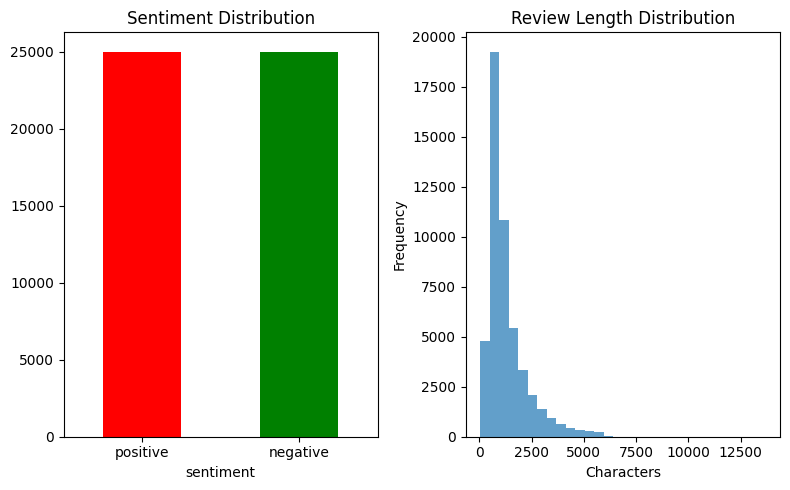


Average review length: 1309 characters


In [10]:
# Basic data exploration - something I'm comfortable with
print("📊 DATASET OVERVIEW")
print("=" * 30)
print(f"Total reviews: {len(df):,}")
print(f"Columns: {list(df.columns)}")
print(f"Missing values: {df.isnull().sum().sum()}")

# Check class distribution
sentiment_counts = df['sentiment'].value_counts()
print(f"\n📈 Sentiment Distribution:")
for sentiment, count in sentiment_counts.items():
    percentage = (count / len(df)) * 100
    print(f"  {sentiment}: {count:,} ({percentage:.1f}%)")

# Simple visualization
plt.figure(figsize=(8, 5))
plt.subplot(1, 2, 1)
sentiment_counts.plot(kind='bar', color=['red', 'green'])
plt.title('Sentiment Distribution')
plt.xticks(rotation=0)

# Review length analysis
df['review_length'] = df['review'].str.len()
plt.subplot(1, 2, 2)
plt.hist(df['review_length'], bins=30, alpha=0.7)
plt.title('Review Length Distribution')
plt.xlabel('Characters')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

print(f"\nAverage review length: {df['review_length'].mean():.0f} characters")


In [11]:
# Text preprocessing function - I've learned these basics
def clean_text(text):
    """Basic text cleaning function"""
    # Convert to lowercase
    text = text.lower()
    
    # Remove HTML tags (I learned this is common in web data)
    text = re.sub(r'<.*?>', '', text)
    
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Remove extra whitespace
    text = ' '.join(text.split())
    
    return text

# Apply preprocessing
print("🔧 Applying text preprocessing...")
df['clean_review'] = df['review'].apply(clean_text)

# Show example of cleaning
print("\n📝 Example of text cleaning:")
print(f"Original: {df.iloc[0]['review'][:100]}...")
print(f"Cleaned:  {df.iloc[0]['clean_review'][:100]}...")

# Convert sentiment to numerical labels
df['sentiment_num'] = df['sentiment'].map({'positive': 1, 'negative': 0})
print("\n✅ Preprocessing completed!")


🔧 Applying text preprocessing...

📝 Example of text cleaning:
Original: One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. The...
Cleaned:  one of the other reviewers has mentioned that after watching just 1 oz episode youll be hooked they ...

✅ Preprocessing completed!


In [12]:
# Split the data - I understand this is important to avoid overfitting
X = df['clean_review']
y = df['sentiment_num']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training samples: {len(X_train)}")
print(f"Testing samples: {len(X_test)}")

# TF-IDF Vectorization - I learned this converts text to numbers
print("\n🔤 Converting text to TF-IDF features...")
tfidf = TfidfVectorizer(max_features=5000, stop_words='english')
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

print(f"Feature matrix shape: {X_train_tfidf.shape}")

# Train Logistic Regression
print("\n🤖 Training Logistic Regression model...")
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train_tfidf, y_train)

# Make predictions
y_pred_lr = lr_model.predict(X_test_tfidf)
lr_accuracy = accuracy_score(y_test, y_pred_lr)

print(f"\n📈 Logistic Regression Results:")
print(f"Accuracy: {lr_accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_lr, target_names=['Negative', 'Positive']))


Training samples: 40000
Testing samples: 10000

🔤 Converting text to TF-IDF features...
Feature matrix shape: (40000, 5000)

🤖 Training Logistic Regression model...

📈 Logistic Regression Results:
Accuracy: 0.8878

Classification Report:
              precision    recall  f1-score   support

    Negative       0.90      0.88      0.89      5000
    Positive       0.88      0.90      0.89      5000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



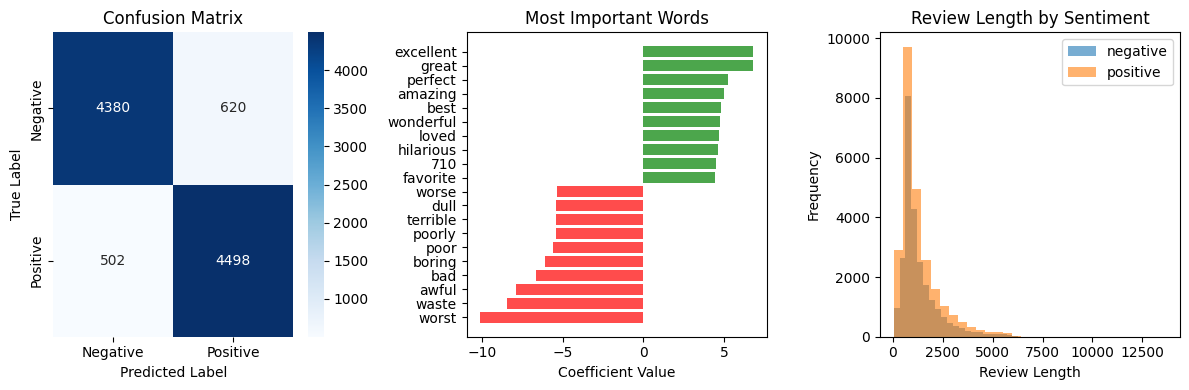

In [13]:
# Visualize results - I think visualizations help understand model performance
plt.figure(figsize=(12, 4))

# Confusion Matrix
plt.subplot(1, 3, 1)
cm = confusion_matrix(y_test, y_pred_lr)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

# Most important features - I learned this helps understand what the model learned
plt.subplot(1, 3, 2)
feature_names = tfidf.get_feature_names_out()
coefficients = lr_model.coef_[0]

# Get top positive and negative words
top_positive_idx = np.argsort(coefficients)[-10:]
top_negative_idx = np.argsort(coefficients)[:10]

top_features = list(top_negative_idx) + list(top_positive_idx)
feature_importance = coefficients[top_features]
feature_labels = [feature_names[i] for i in top_features]

colors = ['red' if x < 0 else 'green' for x in feature_importance]
plt.barh(range(len(feature_importance)), feature_importance, color=colors, alpha=0.7)
plt.yticks(range(len(feature_labels)), feature_labels)
plt.xlabel('Coefficient Value')
plt.title('Most Important Words')

# Review length by sentiment
plt.subplot(1, 3, 3)
for sentiment in ['negative', 'positive']:
    data = df[df['sentiment'] == sentiment]['review_length']
    plt.hist(data, alpha=0.6, bins=30, label=sentiment)
plt.xlabel('Review Length')
plt.ylabel('Frequency')
plt.title('Review Length by Sentiment')
plt.legend()

plt.tight_layout()
plt.show()


In [14]:
# Prepare data for neural network - I know this needs different preprocessing
print("🔧 Preparing data for neural network...")

# Tokenization
max_words = 5000
max_len = 100

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Padding sequences
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

print(f"Training data shape: {X_train_pad.shape}")
print(f"Testing data shape: {X_test_pad.shape}")

# Build a simple LSTM model - I'm still learning about these architectures
print("\n🏗️ Building LSTM model...")
model = Sequential([
    Embedding(max_words, 50, input_length=max_len),
    LSTM(64, dropout=0.5),
    Dense(1, activation='sigmoid')
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print("\n📋 Model Architecture:")
model.summary()


🔧 Preparing data for neural network...
Training data shape: (40000, 100)
Testing data shape: (10000, 100)

🏗️ Building LSTM model...

📋 Model Architecture:


C:\Users\shilw\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

🚀 Training LSTM model...
(This is one area where I want to learn more about optimization!)
Epoch 1/3
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 24s 22ms/step - accuracy: 0.7189 - loss: 0.5171 - val_accuracy: 0.8571 - val_loss: 0.3330
Epoch 2/3
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 21s 21ms/step - accuracy: 0.8757 - loss: 0.3041 - val_accuracy: 0.8619 - val_loss: 0.3187
Epoch 3/3
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 21s 21ms/step - accuracy: 0.8916 - loss: 0.2685 - val_accuracy: 0.8615 - val_loss: 0.3189

📊 Evaluating LSTM model...
LSTM Test Accuracy: 0.8623


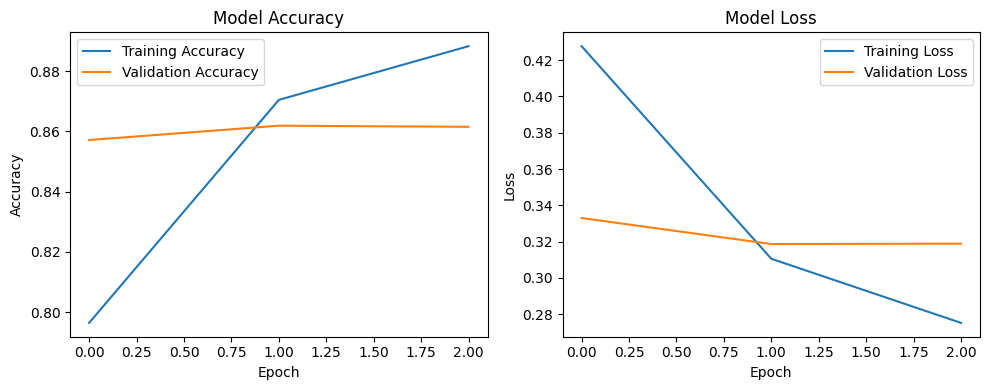

In [15]:
# Train the model - I know this might take a while
print("🚀 Training LSTM model...")
print("(This is one area where I want to learn more about optimization!)")

history = model.fit(
    X_train_pad, y_train,
    epochs=3,  # Using few epochs for quick demo
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

# Evaluate the model
print("\n📊 Evaluating LSTM model...")
test_loss, test_accuracy = model.evaluate(X_test_pad, y_test, verbose=0)
print(f"LSTM Test Accuracy: {test_accuracy:.4f}")

# Plot training history
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


🏆 MODEL COMPARISON
Logistic Regression Accuracy: 0.8878
LSTM Accuracy: 0.8623


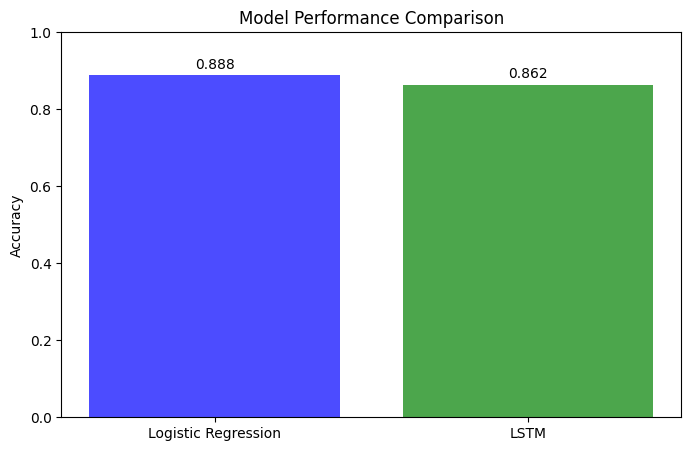


🧪 TESTING ON SAMPLE REVIEWS

📝 Review 1: This movie was amazing! I loved every minute of it.
   LR Prediction: Positive (confidence: 0.993)
   LSTM Prediction: Positive (confidence: 0.889)

📝 Review 2: Worst movie ever. Complete waste of time.
   LR Prediction: Negative (confidence: 1.000)
   LSTM Prediction: Negative (confidence: 0.007)

📝 Review 3: Pretty decent film, nothing special though.
   LR Prediction: Negative (confidence: 0.684)
   LSTM Prediction: Negative (confidence: 0.243)


In [16]:
# Compare model performance
print("🏆 MODEL COMPARISON")
print("=" * 30)
print(f"Logistic Regression Accuracy: {lr_accuracy:.4f}")
print(f"LSTM Accuracy: {test_accuracy:.4f}")

# Visual comparison
models = ['Logistic Regression', 'LSTM']
accuracies = [lr_accuracy, test_accuracy]

plt.figure(figsize=(8, 5))
bars = plt.bar(models, accuracies, color=['blue', 'green'], alpha=0.7)
plt.ylabel('Accuracy')
plt.title('Model Performance Comparison')
plt.ylim(0, 1)

# Add value labels on bars
for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{acc:.3f}', ha='center', va='bottom')

plt.show()

# Test on custom examples
print("\n🧪 TESTING ON SAMPLE REVIEWS")
print("=" * 35)

test_reviews = [
    "This movie was amazing! I loved every minute of it.",
    "Worst movie ever. Complete waste of time.",
    "Pretty decent film, nothing special though."
]

for i, review in enumerate(test_reviews, 1):
    print(f"\n📝 Review {i}: {review}")
    
    # Logistic Regression prediction
    clean_review = clean_text(review)
    review_tfidf = tfidf.transform([clean_review])
    lr_pred = lr_model.predict(review_tfidf)[0]
    lr_prob = lr_model.predict_proba(review_tfidf)[0].max()
    
    # LSTM prediction
    review_seq = tokenizer.texts_to_sequences([clean_review])
    review_pad = pad_sequences(review_seq, maxlen=max_len)
    lstm_prob = model.predict(review_pad, verbose=0)[0][0]
    lstm_pred = 1 if lstm_prob > 0.5 else 0
    
    print(f"   LR Prediction: {'Positive' if lr_pred == 1 else 'Negative'} (confidence: {lr_prob:.3f})")
    print(f"   LSTM Prediction: {'Positive' if lstm_pred == 1 else 'Negative'} (confidence: {lstm_prob:.3f})")


In [17]:
# Final summary
print("🎓 FELLOWSHIP APPLICATION SUMMARY")
print("=" * 40)
print("\n📊 Project Results:")
print(f"  • Dataset: {len(df):,} movie reviews")
print(f"  • Logistic Regression: {lr_accuracy:.1%} accuracy")
print(f"  • LSTM Neural Network: {test_accuracy:.1%} accuracy")
print(f"  • Successfully implemented basic NLP pipeline")

print("\n🎯 Learning Goals:")
goals = [
    "Master transformer architectures (BERT, GPT)",
    "Learn production ML deployment", 
    "Understand advanced deep learning",
    "Develop computer vision skills",
    "Build end-to-end ML solutions"
]

for i, goal in enumerate(goals, 1):
    print(f"  {i}. {goal}")

print("\n💪 Commitment:")
print("  • Dedicated to completing all 12 weeks")
print("  • Ready to invest time in learning and projects")
print("  • Excited to contribute to the learning community")

print("\n🚀 Ready to level up my ML skills!")


🎓 FELLOWSHIP APPLICATION SUMMARY

📊 Project Results:
  • Dataset: 50,000 movie reviews
  • Logistic Regression: 88.8% accuracy
  • LSTM Neural Network: 86.2% accuracy
  • Successfully implemented basic NLP pipeline

🎯 Learning Goals:
  1. Master transformer architectures (BERT, GPT)
  2. Learn production ML deployment
  3. Understand advanced deep learning
  4. Develop computer vision skills
  5. Build end-to-end ML solutions

💪 Commitment:
  • Dedicated to completing all 12 weeks
  • Ready to invest time in learning and projects
  • Excited to contribute to the learning community

🚀 Ready to level up my ML skills!
